In [1]:

import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  


# Did the Hall of Fame voter purge make a difference?

In a recent Jayson Stark article and about [lessons in hall of fame voting](http://espn.go.com/mlb/story/_/id/14521041/five-things-learned-2016-hall-fame-election), he mentions the following three assumptions about the Baseball Hall of fame voters after a significant number of non-active voters were eliminated:

> An electorate in which 109 fewer writers cast a vote in this election than in 2015.
>
> An electorate that had a much different perspective on players who shined brightest under the light of new-age metrics.
>
> And an electorate that appeared significantly less judgmental of players shadowed by those pesky performance-enhancing drug clouds.

However, are these last two assumptions true?  Did the purge of Hall of Fame voters make a difference?  Did the set of Hall of Fame voters least active have a different set of values than the those who are still voting? 


Arbitrarily, I decided to test this against the years 1995-2016, which gives a good 20 elections as well as starting at the year Mike Schmidt was elected to the Hall of Fame (which is utterly arbitrary other than Mike Schmidt being my favorite player when I was young).  However to figure this out, the first question that has to be answer is how does the average percentage change from year to year.  This ends up being a little surprising when you just look at the numbers: 

In [2]:
#read in the data
def read_votes(infile):
    """Read in the number of votes in each file"""
    lines = open(infile).readlines()
    hof_votes = {}
    for l in lines:
        player={}
        l = l.split(',')
        name = l[1].replace('X-', '').replace(' HOF', '').strip()
        player['year'] = l[2]
        player['votes'] = float(l[3])
        player['p'] = float(l[4][:-1])/100.0
        player['war'] = float(l[8])
        hof_votes[name] = player
    return hof_votes


#calcuate the total number of votes in each year
hof={}
n_votes = {}
for i in np.arange(1996, 2017):
    hof[i] = read_votes('{}_list.csv'.format(i))
    k=0
    keys = hof[i].keys()
    while hof[i][keys[k]]['p']<0.5: k+=1
    k = keys[k]
    n_votes[i] = int ( hof[i][k]['votes'] / hof[i][k]['p'])
n_years = 2017-1996

In [3]:
def match_years(hof, year1, year2):
    "Produce a list of players and the number of votes received between two years"
    player_dict={}
    for name in hof[year1].keys():
        if name in hof[year2].keys():
            player_dict[name]=np.array([hof[year1][name]['p'], hof[year2][name]['p']])
    return player_dict


In [4]:
end_year = 2017
def number_of_first_year(hof, year):
    "Calculate the number of first ballot hall of famers in a class"
    first_year = 0
    for name in hof[year]:
        if hof[year][name]['year']=='1st':
           if hof[year][name]['p']>0.75: first_year+= 1
           if name in ['Barry Bonds', 'Roger Clemens']: first_year+= 1
    return first_year


def number_of_HOF(hof, year):
    "Calculte the number of HOF for a year"
    first_year = 0
    for name in hof[year]:
        if hof[year][name]['p']>0.75: first_year+= 1
    return first_year

def number_of_drop(hof, year):
    "Calculate the number of players dropped in a year"
    first_year = 0
    for name in hof[year]:
        if hof[year][name]['p']<0.05: first_year+= 1
    return first_year


In [5]:
def total_number_of_hof(hof, year):
    "Total number of hall of famers for a class"
    first_year = 0
    for name in hof[year]:
        if hof[year][name]['year']=='1st':
           if hof[year][name]['p']>0.75: 
              first_year+= 1
           if name in ['Barry Bonds', 'Roger Clemens']: first_year+= 1
           for y in range(year+1, end_year):
               if name in hof[y].keys():
                    #print year, name, hof[y][name]['p']
                    if hof[y][name]['p']>0.75: 
                        first_year+= 1
    return first_year


In [6]:
def average_change_in_votes(hof, year1, year2):
    """Determine the statistics change in votes from one class to another"""
    player_dict = match_years(hof, year1, year2)
    #print player_dict
    change = 0
    count = 0
    for name in player_dict:
        change += player_dict[name][1] - player_dict[name][0]
        count += 1
        #print count, name, player_dict[name][0], player_dict[name][1], player_dict[name][1] - player_dict[name][0], change
    change = change / count
    return count, change


In [7]:
def number_of_votes(hof, year):
    keys = hof[year].keys()
    k=0
    while hof[year][keys[k]]['p']<0.5: k+=1
    k = keys[k]
    return int ( hof[year][k]['votes'] / hof[year][k]['p'])


In [12]:
from astropy.table import Table
data_table = Table(names=('Year','Votes', 'Strength', 'HOF', 'Drop', 'Count', 'Change', 'Total'))
for year in np.arange(1997,2017):
    strength = number_of_first_year(hof, year)
    nhof = number_of_HOF(hof, year)
    nvotes = number_of_votes(hof, year)
    ndrop = number_of_drop(hof, year)
    total = total_number_of_hof(hof, year)
    count, change = average_change_in_votes(hof, year-1, year)
    data_table.add_row([year, nvotes, strength, nhof, ndrop, count, change, total])


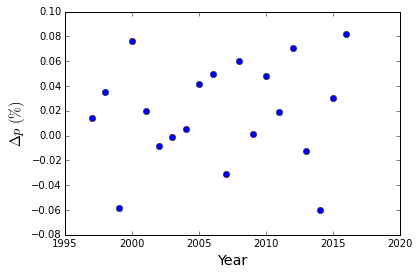

In [13]:
plt.figure()
plt.plot(data_table['Year'], data_table['Change'], ls='', marker='o')
plt.xlabel('Year', fontsize='x-large')
plt.ylabel('$\Delta p \ (\%)$', fontsize='x-large')
plt.show()


In [14]:
'Mean={}  Std={}'.format(data_table['Change'].mean(), data_table['Change'].std())
'Max={}  Min={}'.format(data_table['Change'].max(), data_table['Change'].min())

'Max=0.0822352941176  Min=-0.0601764705882'

As a matter of fact, this year saw one of the largest increases at 8.2%.  Taken alone, this may indicate that something has changed with the removal of so many voters, but when viewed with all the other years, it does not look very exceptional as the values range between -6 to +8%.  The average change is an increase by 2% per year, but with a standard deviation much larger than it of 4%.  *The average change in percentage is either highly random or driven by something other than change in the number of votes.*  In fact, the change in percentages does not show any strong correlation with the number of voters or the change in number of voters.  


In [15]:
stats.pearsonr(data_table['Year'], data_table['Change'])


(0.12433150236202198, 0.60148997659379133)

In [16]:
stats.pearsonr(data_table['Votes'], data_table['Change'])


(-0.18919150246965624, 0.42436872449811769)

In [17]:
stats.pearsonr(data_table['Votes'][1:]-data_table['Votes'][:-1], data_table['Change'][1:])


(-0.40589419128970977, 0.084659001306052251)

In [18]:
data_table['Year', 'Votes', 'Count', 'Change', 'Strength','Total', 'HOF', 'Drop'].show_in_notebook(display_length=21)
#['Year', 'Count', 'Change', 'Strength', 'HOF', 'Drop']



Year,Votes,Count,Change,Strength,Total,HOF,Drop
1997.0,473.0,22.0,0.0140909090909,0.0,1.0,1.0,10.0
1998.0,472.0,17.0,0.0349411764706,0.0,2.0,1.0,7.0
1999.0,496.0,17.0,-0.0581176470588,3.0,4.0,3.0,7.0
2000.0,498.0,16.0,0.07625,0.0,1.0,2.0,13.0
2001.0,514.0,15.0,0.02,2.0,2.0,2.0,13.0
2002.0,472.0,17.0,-0.00876470588235,1.0,2.0,1.0,10.0
2003.0,496.0,16.0,-0.0015,1.0,2.0,2.0,13.0
2004.0,505.0,17.0,0.00564705882353,2.0,2.0,2.0,15.0
2005.0,515.0,15.0,0.0414,1.0,1.0,2.0,10.0
2006.0,520.0,15.0,0.0496666666667,0.0,0.0,1.0,13.0


## Correlations with Hall of Fame classes

At initial glance, there is not much pattern to the data so pure randomness could be an explanation.  However, we can define a few other metrics to take a look at the data and it might give us a better idea of what is going on.  The first would be the number of Hall of Famers (hofs) elected in the previous class.  The second is defined as the strength of the class as the number of first ballot hofs in that class (For the record, I consider Bonds and Clemons as first ballot hall of famers as the would have been if not for their Performance Enhancing Drug (PED) history).  The third is the total number of hofs in a class, but that is uncertain for the most recent classes.    

A very strong trend does appears between the average change in the percentage and the strength of an incoming class minus the number of hofs elected the year before.  Unsurprisingly, when a strong class comes onto the ballot, they tend to take votes away from other players. Likewise, when a large number of players are elected, they free up votes for other players.  A linear relationship of $$s = 0.0299*nhof_{previous} -0.0221\times Strength - 0.0034\times(Total-Strength) - 0.00299$$ gives a very good fit to  $\Delta p$ and shows a strong linear correlation indicated by an r-pearson statistic of 0.95.  

In [19]:
nhof_2 = data_table['Total'][1:]- data_table['Strength'][1:] #number of HOFs in a class after year 1

p = data_table['Change'][1:]  
dv = data_table['Votes'][1:] - data_table['Votes'][:-1]



In [20]:
from scipy import linalg as la
aa = np.vstack((data_table['Strength'][1:],nhof_2,data_table['HOF'][:-1], np.ones_like(nhof_2))).T
polycofs = la.lstsq(aa[:-1], p[:-1])[0]
print polycofs

[-0.0221596  -0.00347177  0.02892667 -0.00299066]


In [21]:
s = aa * polycofs 
s = s.sum(axis=1)
s

array([ 0.01899247, -0.04401456,  0.08031758,  0.01054347,  0.02923131,
        0.00030464,  0.01054347,  0.03270307,  0.05486268, -0.0183832 ,
        0.05486268,  0.00377641,  0.04791914,  0.02593601,  0.05486268,
       -0.02532673, -0.06946947,  0.01731054,  0.09055641])

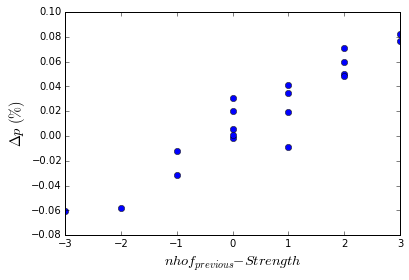

(0.94973196989687392, 5.3216490374234465e-10)


In [22]:
plt.figure()
plt.plot(data_table['HOF'][:-1]-data_table['Strength'][1:], p, ls='', marker='o')
plt.xlabel('$nhof_{previous} - Strength$', fontsize='x-large')
plt.ylabel('$\Delta p \ (\%)$', fontsize='x-large')
plt.show()
from scipy import stats
print stats.pearsonr(s,p)

In [23]:
Table((data_table['Year'][1:],data_table['HOF'][:-1]-data_table['Strength'][1:],p)).show_in_notebook()


Year,HOF,Change
1998.0,1.0,0.0349411764706
1999.0,-2.0,-0.0581176470588
2000.0,3.0,0.07625
2001.0,0.0,0.02
2002.0,1.0,-0.00876470588235
2003.0,0.0,-0.0015
2004.0,0.0,0.00564705882353
2005.0,1.0,0.0414
2006.0,2.0,0.0496666666667
2007.0,-1.0,-0.0312666666667


In [24]:
coef = np.polyfit(s,p,1)
np.polyval(coef,0.08)
print s[-1]
print coef

0.0905564147749
[  9.80227040e-01  -4.71478086e-05]


## Change in Voting Habits


If we use this relationship, we can look at what the expected percentage average change in the votes were for 2016.   The expected change based on the existing data (1 First ballot hofs, 4  hofs the previous year, 1 total hof for class of 2016) was an increase of +9.0%.  The average increase for 2016?   That was +8.2%.  So, at least overall, the increase in percentages is exactly what was expected based on a moderate incoming class (if you also assume Trevor Hoffman will eventually be elected the expected change for this year is then 8.7%) and four players entering the Hall the previous year.  **From this perspective, the voting purge made little difference in how the  percentage of votes for a player changed.**  

In [25]:
name_list = []
p_list = []
dp_list = []
pp_list = []
year1 = 2015
year2 = year1+1
expect_p = s[year2 - 1998]
print year2,  expect_p

2016 0.0905564147749


Historically, players with higher vote percentage generally have seen their voting percentages increase.    In the figure below, we look at the difference between the change in vote percentage for a given player, $\Delta p$, and the expected average change for all players that year as compared to the player's percentage, p, for the previous year.   The 2016 year (red squares) does not appear significantly different than any other years (blue circles).  It is just more common that players with low vote percentages tend to have their vote percentages suppressed than players with higher vote percentages.   Nonetheless, there is large scatter in the distribution, which for any given player in any given year does not make it very predictive.   

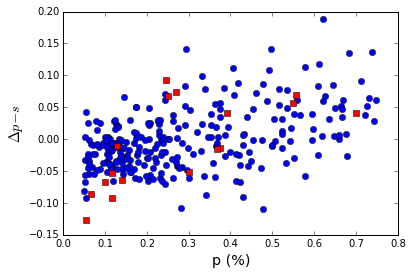

In [26]:
plt.figure()
name_list=[]
p_list=[]
pp_list=[]
dp_list=[]
war_list=[]
for year1 in range(1997,2015):
    year2 = year1+1
    expect_p = s[year2 - 1998]
    for name in hof[year1]:
        if name in hof[year2].keys():  
            name_list.append(name)
            p_list.append(hof[year1][name]['p'])
            dp_list.append(hof[year2][name]['p'] - hof[year1][name]['p'])
            pp_list.append((hof[year2][name]['p'] - hof[year1][name]['p'])-expect_p)
            war_list.append(hof[year2][name]['war'])
plt.plot(p_list, pp_list, 'bo')

name_list=[]
p_2016_list=[]
pp_2016_list=[]
dp_2016_list=[]
war_2016_list = []
year1=2015
year2 = year1+1
expect_p = s[year2 - 1998]
for name in hof[year1]:
    if name in hof[year2].keys():  
        name_list.append(name)
        p_2016_list.append(hof[year1][name]['p'])
        dp_2016_list.append(hof[year2][name]['p'] - hof[year1][name]['p'])
        pp_2016_list.append((hof[year2][name]['p'] - hof[year1][name]['p'])-expect_p)
        war_2016_list.append(hof[year2][name]['war'])
plt.plot(p_2016_list, pp_2016_list, 'rs')
plt.xlabel('p (%)', fontsize='x-large')
plt.ylabel('$\Delta p - s $', fontsize='x-large')
plt.show()

### Have voters changed in terms of WAR or PEDs?

If we look at the corrected change in voting percentage as a function of WAR, there does appear to be a stronger correlation between WAR and percentage change this year (red and green squares) than seen last year (blue circles), although some correlation does exist.  The three points not falling near the correlation are Barry Bonds and Roger Clemons (PED history for otherwise certain hofs) and Lee Smith (reliever).  Going back further years shows a large scatter in terms of WAR and corrected percentage change, and it would be interesting to see how this has changed over all the different years and to see if the strength of this correlation has been increasing.  Furthermore, it would be interesting to see how this relates to a players other, more traditional metrics like home runs or wins.   

The green circles are players that have been a strongly association with PEDs.  Barry Bonds and Roger Clemons are exceptions, but the drop in the percentages for the other three players is in line for the drop for players with similar values of WAR.   Along with the average change in voting seen for Bonds and Clemons, it does not look like the behavior for players associated with PEDs is very different than other players.   



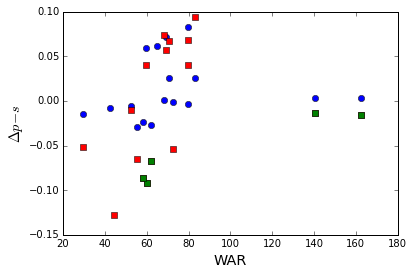

In [27]:
plt.plot(war_list[-17:], pp_list[-17:], 'bo')
mask = np.zeros(len(war_2016_list), dtype=bool)
for i, name in enumerate(name_list):
    if name in ['Sammy Sosa', 'Gary Sheffield', 'Mark McGwire', 'Barry Bonds', 'Roger Clemens']:
        mask[i]=True

war = np.array(war_2016_list)
pp = np.array(pp_2016_list)
plt.plot(war, pp, 'rs')
plt.plot(war[mask], pp[mask], 'gs')
plt.xlabel('WAR', fontsize='x-large')
plt.ylabel('$\Delta p - s $', fontsize='x-large')
plt.show()

In [28]:
Table((name_list, p_2016_list, dp_2016_list, pp_2016_list, war_2016_list)).show_in_notebook()

col0,col1,col2,col3,col4
Lee Smith,0.302,0.039,-0.0515564147749,29.6
Jeff Kent,0.14,0.026,-0.0645564147749,55.2
Edgar Martinez,0.27,0.164,0.0734435852251,68.3
Alan Trammell,0.251,0.158,0.0674435852251,70.4
Larry Walker,0.118,0.037,-0.0535564147749,72.6
Curt Schilling,0.392,0.131,0.0404435852251,79.9
Roger Clemens,0.375,0.077,-0.0135564147749,140.3
Mike Mussina,0.246,0.184,0.0934435852251,83.0
Gary Sheffield,0.117,-0.001,-0.0915564147749,60.3
Sammy Sosa,0.066,0.004,-0.0865564147749,58.4


## Conclusions and other thoughts

The overall average change in vote percentage was almost exactly what was predicted based on the strength of the incoming class and the large number of Hall of Famers elected the previous year.   Along with the fact that percentages tend to increase relative to the average change for players with higher percentages, it does not look like there were any major changes to the voter patterns between this year and last year due to the *purge* of voters.


In terms of players that took PEDs, no major differences are detected in the voting patterns as compared to other players or the previous year.    

In terms of WAR, the percentage change for a player does seem to correlate with WAR and possible has become a stronger correlation.  

However, it should be noted that this is one year, a relatively small sample size, and that something very different could be occurring here. 

Relievers still are an exceptional case with Lee Smith having a very low WAR.  His vote percentage did decrease relative to the overall class and it will be interesting to see what happens to the three relieviers (Trevor Hoffman and Billy Wagner along with Lee Smith) next year.   If Lee Smith is an example of how the new group of voters view relievers, we would expect to see all of their percentages drop relative to the average change, but it will be interesting as Trevor Hoffman is already very close. 

The player with the worst performance though was Nomar Garciaparra with a drop in voting percentage of -12% as compared to the average.  He was never associated with PEDs, and this was arguably expected due to being the lowest, second year positional player by WAR on the ballot.  On the other hand, the player with the largest increase, Mike Mussina, has the largest WAR of any player outside of Bonds or Clemons.  

As a final aside, Jeff Bagwell, Curt Schilling, and Mike Mussina are the only players in the last 20 years with no known associated with PEDs and WAR > 75 to not be elected, so far,  to the hall of fame.   Along with Phil Neikro and Bert Blyleven (and exlcuding Roger Clemons and Barry Bonds), these five players are the only players with WAR > 75 and not be elected on their first ballot in the last twenty years, whereas 13 other players with WAR > 75 were elected on their first ballot.  

George Brett 88.4 0.982
Robin Yount 77.0 0.775
Nolan Ryan 81.8 0.988
Ozzie Smith 76.5 0.917
Paul Molitor 75.4 0.852
Wade Boggs 91.1 0.919
Cal Ripken 95.5 0.985
Rickey Henderson 110.8 0.948
Tom Glavine 81.4 0.919
Greg Maddux 106.9 0.972
Pedro Martinez 84.0 0.911
Randy Johnson 102.1 0.973
Ken Griffey 83.6 0.993


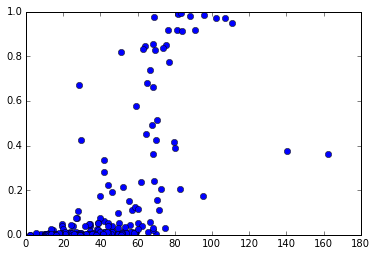

In [29]:
plt.figure()

for year in range(1996,2017):
    for name in hof[year].keys():
        if hof[year][name]['year']=='1st' :
            w = hof[year][name]['war']
            p = hof[year][name]['p']
            plt.plot([w], [p], 'bo') 
            if p > 0.75 and w > 75: print name, w, p
plt.show()